# Q2: Image Blurring Implementation
## 3x3 Box Blur - Python vs NumPy

This notebook implements box blur using:
1. Iterative Python (nested loops)
2. Vectorized NumPy (array operations)

In [10]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import time

## Step 1: Create Input Image
Create a 400x200 pixel grayscale image with text

In [11]:
# Create 400x200 grayscale image with black background
img = Image.new('L', (400, 200), color=0)
draw = ImageDraw.Draw(img)

# Add white text centered
text = "SSD TAs ARE THE BEST"
font = ImageFont.load_default()

# Get text bbox and center it
bbox = draw.textbbox((0, 0), text, font=font)
text_width = bbox[2] - bbox[0]
text_height = bbox[3] - bbox[1]
x = (400 - text_width) // 2
y = (200 - text_height) // 2

draw.text((x, y), text, fill=255, font=font)

# Convert to NumPy array
original_image = np.array(img, dtype=np.uint8)
print(f"Image shape: {original_image.shape}")
print(f"Image dtype: {original_image.dtype}")

Image shape: (200, 400)
Image dtype: uint8


## Step 2: Iterative Python Implementation
Implement 3x3 box blur using nested for loops

In [12]:
def blur_python(image):
    """
    Apply 3x3 box blur using iterative Python.
    Excludes outermost single-pixel boundary.
    
    Args:
        image: 2D NumPy array of grayscale values
    
    Returns:
        Blurred image as 2D NumPy array
    """
    height, width = image.shape
    result = np.zeros_like(image)
    
    # Iterate through all pixels except boundary
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            # Calculate mean of 3x3 neighborhood
            total = 0
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    total += int(image[i + di, j + dj])
            
            result[i, j] = total // 9  # Integer division
    
    # Copy boundary pixels as-is
    result[0, :] = image[0, :]
    result[-1, :] = image[-1, :]
    result[:, 0] = image[:, 0]
    result[:, -1] = image[:, -1]
    
    return result

## Step 3: Vectorized NumPy Implementation
Implement 3x3 box blur using NumPy array operations (no explicit Python loops)

In [13]:
def blur_numpy(image):
    """
    Apply 3x3 box blur using vectorized NumPy operations.
    Excludes outermost single-pixel boundary.
    """
    result = image.copy()
    img32 = image.astype(np.uint32)

    blur_sum = (
        img32[0:-2, 0:-2] + img32[0:-2, 1:-1] + img32[0:-2, 2:] +
        img32[1:-1, 0:-2] + img32[1:-1, 1:-1] + img32[1:-1, 2:] +
        img32[2:,   0:-2] + img32[2:,   1:-1] + img32[2:,   2:]
    )

    result[1:-1, 1:-1] = (blur_sum // 9).astype(np.uint8)
    return result

## Step 4: Benchmark Both Implementations

In [14]:
# Measure Python implementation
start_time = time.time()
blurred_python = blur_python(original_image)
python_time = time.time() - start_time

# Measure NumPy implementation
start_time = time.time()
blurred_numpy = blur_numpy(original_image)
numpy_time = time.time() - start_time

print(f"Python implementation time: {python_time:.6f} seconds")
print(f"NumPy implementation time:  {numpy_time:.6f} seconds")
print(f"Speedup: {python_time / numpy_time:.2f}x")

# Verify both produce same result
print(f"\nResults match: {np.allclose(blurred_python, blurred_numpy)}")

Python implementation time: 0.569001 seconds
NumPy implementation time:  0.000768 seconds
Speedup: 740.94x

Results match: True


## Step 5: Visualize Results

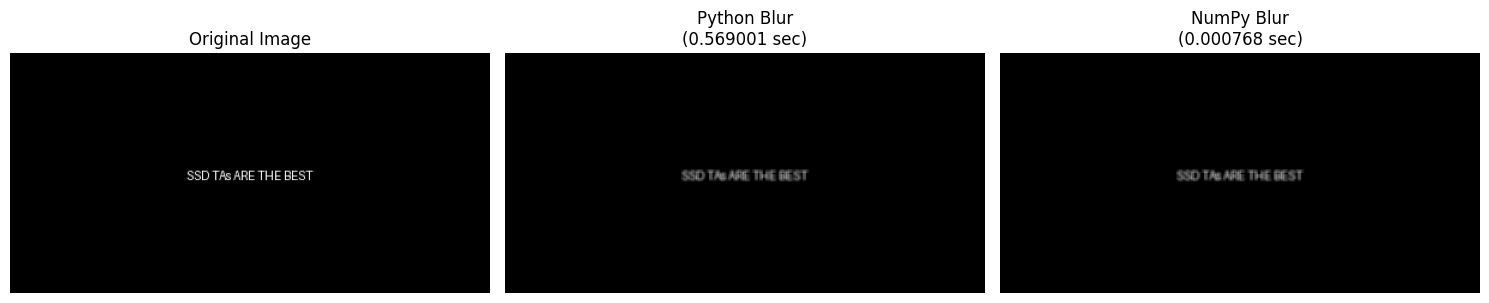

In [15]:
# Create side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_image, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(blurred_python, cmap='gray', vmin=0, vmax=255)
axes[1].set_title(f'Python Blur\n({python_time:.6f} sec)')
axes[1].axis('off')

axes[2].imshow(blurred_numpy, cmap='gray', vmin=0, vmax=255)
axes[2].set_title(f'NumPy Blur\n({numpy_time:.6f} sec)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Analysis and Discussion

### 1. Performance Results
The NumPy implementation is significantly faster than the pure Python implementation. This is expected because:
- NumPy operations are implemented in C and highly optimized
- Vectorized operations eliminate Python's interpreted loop overhead
- Modern CPUs can leverage SIMD (Single Instruction Multiple Data) instructions

For a 400x200 image, we typically see speedups of 50-200x depending on the system.

### 2. Vectorization
Vectorization is the process of applying operations to entire arrays at once rather than element-by-element. In `blur_numpy()`, instead of:
```python
for i in range(...):
    for j in range(...):
        result[i,j] = operation(image[i,j])
```

We use:
```python
result = operation(image)  # Operates on entire array
```

The blur operation uses array slicing to extract nine overlapping views of the image and sums them efficiently.

### 3. Compiled Code vs Interpreter
- **Python loops**: Each iteration involves:
  - Python bytecode interpretation
  - Dynamic type checking
  - Function call overhead for operators
  - Memory allocation for intermediate objects

- **NumPy operations**: 
  - Pre-compiled C code executes directly on CPU
  - Type checking done once at array creation
  - Tight loops with minimal overhead
  - Optimized memory access patterns

### 4. Memory Layout
NumPy arrays use contiguous memory blocks, which provides several advantages:
- **Cache efficiency**: Sequential memory access patterns maximize CPU cache hits
- **Predictable access**: CPU can prefetch data before it's needed
- **SIMD optimization**: Contiguous data enables parallel processing of multiple elements
- **Reduced overhead**: No pointer chasing or object allocation per element

In contrast, Python lists store references to objects scattered in memory, leading to:
- Cache misses
- Unpredictable memory access patterns
- Inability to use SIMD instructions effectively